In [43]:
#Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
#Load the dataset from uploaded location
filepath = '/content/station_data_dataverse.csv'
data = pd.read_csv(filepath)

In [45]:
#Display the first few rows of the dataset and check for missing values and datatypes
print("Shape of the dataset:")
print(data.shape)

data_head= data.head()
print("First five rows of the dataset:")
print(data.head())

missing_values=data.isnull().sum()
print("Number of missing values in the dataset,coloumn wise:")
print(missing_values)

data_types = data.dtypes
print("Data types of each column:")
print(data.dtypes)


Shape of the dataset:
(3395, 24)
First five rows of the dataset:
   sessionId  kwhTotal  dollars              created                ended  \
0    1366563      7.78     0.00  0014-11-18 15:40:26  0014-11-18 17:11:04   
1    3075723      9.74     0.00  0014-11-19 17:40:26  0014-11-19 19:51:04   
2    4228788      6.76     0.58  0014-11-21 12:05:46  0014-11-21 16:46:04   
3    3173284      6.17     0.00  0014-12-03 19:16:12  0014-12-03 21:02:18   
4    3266500      0.93     0.00  0014-12-11 20:56:11  0014-12-11 21:14:06   

   startTime  endTime  chargeTimeHrs weekday platform  ...  managerVehicle  \
0         15       17       1.510556     Tue  android  ...               0   
1         17       19       2.177222     Wed  android  ...               0   
2         12       16       4.671667     Fri  android  ...               0   
3         19       21       1.768333     Wed  android  ...               0   
4         20       21       0.298611     Thu  android  ...               0   

   

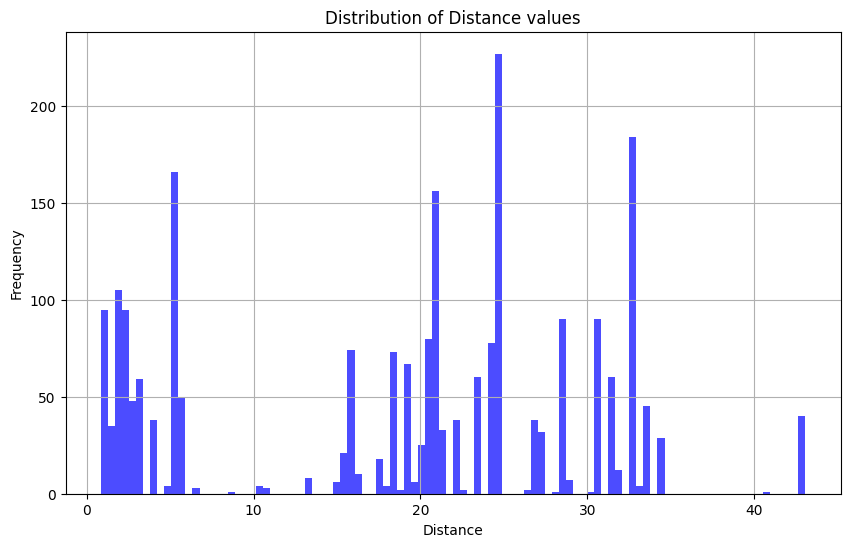

In [46]:
#'distance' column has lot of missing values
#plot the distribution of the 'distance' column

plt.figure(figsize=(10,6))
plt.hist(data['distance'].dropna(),bins=100,color='blue',alpha =0.7)
plt.title('Distribution of Distance values')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [47]:
#Remove rows where 'distance' is missing
cleaned_data = data.dropna(subset=['distance'])

#Print the shape of the data before and after removal of missing values to see how many rows where removed
print("Original data shape:", data.shape)
print("Cleaned data shape:",cleaned_data.shape)

Original data shape: (3395, 24)
Cleaned data shape: (2330, 24)


In [48]:
print(cleaned_data.head())

     sessionId  kwhTotal  dollars              created                ended  \
343    7093670      5.61      0.0  0014-11-18 15:01:17  0014-11-18 18:26:04   
344    3730551      9.03      0.0  0014-11-19 19:01:41  0014-11-19 22:10:06   
345    7080329      6.95      0.0  0014-11-20 19:20:45  0014-11-20 21:48:04   
346    3829635      7.38      0.0  0014-11-21 19:02:04  0014-11-21 21:31:03   
347    6139758      6.69      0.0  0014-11-24 17:16:19  0014-11-24 19:31:04   

     startTime  endTime  chargeTimeHrs weekday platform  ...  managerVehicle  \
343         15       18       3.413056     Tue      ios  ...               0   
344         19       22       3.140278     Wed      ios  ...               0   
345         19       21       2.455278     Thu      ios  ...               0   
346         19       21       2.483056     Fri      ios  ...               0   
347         17       19       2.245833     Mon      ios  ...               0   

     facilityType  Mon  Tues  Wed  Thurs  Fr

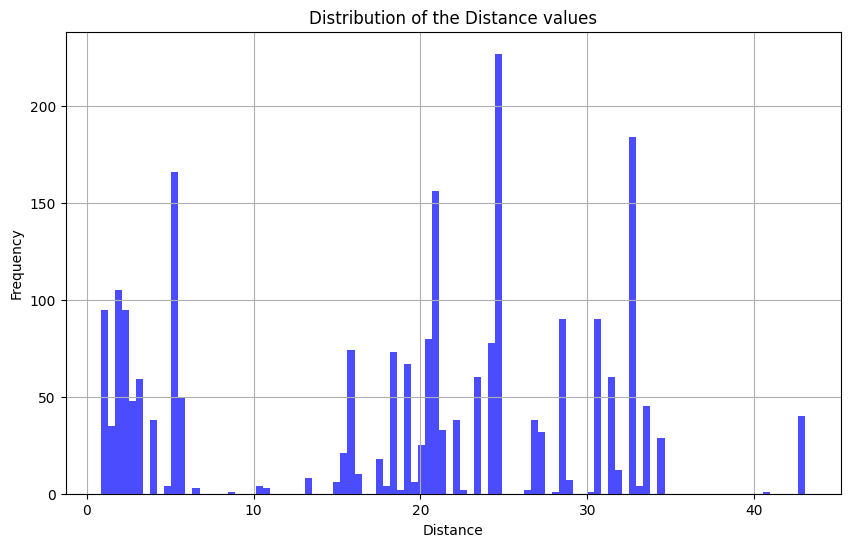

In [49]:
#Plot distribution of the 'distance' column after removing the missing values
plt.figure(figsize=(10,6))
plt.hist(cleaned_data['distance'].dropna(), bins =100, color= 'blue', alpha=0.7)
plt.title('Distribution of the Distance values')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()